In [105]:
import numpy as np
import tensorflow as tf
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')

import datasets

In [5]:
data_path = '../data/yearly_24.h5'
model_path = '../results/benchmark_all_windows/inp_18__41/weights_epoch_012.h5'

In [7]:
data = datasets.seq2seq_generator(data_path, batch_size=2048)
model = tf.keras.models.load_model(model_path)

In [9]:
batch = iter(data).__next__()

In [12]:
batch[0].shape

TensorShape([2048, 18, 1])

In [13]:
preds = model.predict(batch)

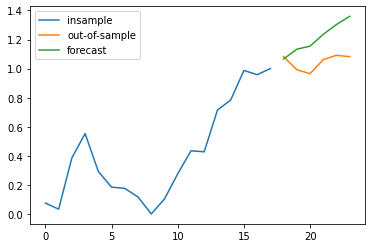

In [31]:
i = 4

plt.plot(range(18), batch[0][i], label='insample')
plt.plot(range(18, 24), batch[1][i], label='out-of-sample')
plt.plot(range(18, 24), preds[i], label='forecast')
plt.legend()

In [28]:
new_batch = np.concatenate([batch[0][:, 6:, :], preds[:, :6, :]], axis=1)

In [29]:
new_batch.shape

(2048, 18, 1)

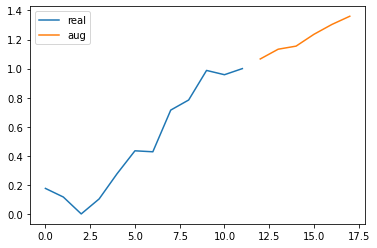

In [32]:
plt.plot(range(12), new_batch[i, :12, 0], label='real')
plt.plot(range(12, 18), new_batch[i, 12:, 0], label='aug')
plt.legend()

In [36]:
preds2 = model.predict(new_batch)

In [37]:
new_batch2 = np.concatenate([new_batch[:, 6:, :], preds2[:, :6, :]], axis=1)
new_batch2.shape

(2048, 18, 1)

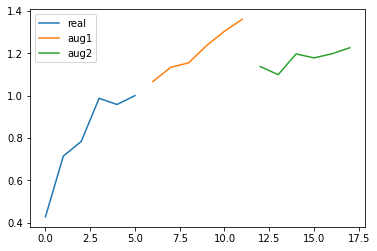

In [38]:
plt.plot(range(6), new_batch2[i, :6, 0], label='real')
plt.plot(range(6, 12), new_batch2[i, 6:12, 0], label='aug1')
plt.plot(range(12, 18), new_batch2[i, 12:, 0], label='aug2')
plt.legend()

In [71]:
def predict_on_unscaled(batch):
    x = batch[..., 0]
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
    x_sc = (x - mn) / (mx - mn)
    pred = model(x_sc[..., np.newaxis])
    return pred[..., 0] * (mx - mn) + mn

In [72]:
preds3 = predict_on_unscaled(new_batch)
preds3.shape

TensorShape([2048, 6])

In [73]:
new_batch3 = np.concatenate([new_batch[:, 6:, :], preds3[:, :6, np.newaxis]], axis=1)
new_batch3.shape

(2048, 18, 1)

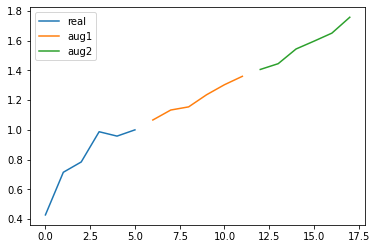

In [74]:
plt.plot(range(6), new_batch3[i, :6, 0], label='real')
plt.plot(range(6, 12), new_batch3[i, 6:12, 0], label='aug1')
plt.plot(range(12, 18), new_batch3[i, 12:, 0], label='aug2')
plt.legend()

In [76]:
preds4 = predict_on_unscaled(new_batch3)
new_batch4 = np.concatenate([new_batch3[:, 6:, :], preds4[:, :6, np.newaxis]], axis=1)
new_batch4.shape

(2048, 18, 1)

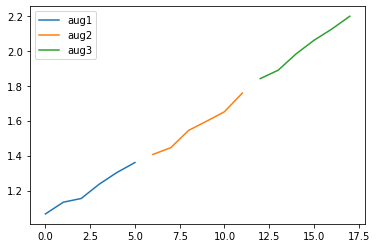

In [77]:
plt.plot(range(6), new_batch4[i, :6, 0], label='aug1')
plt.plot(range(6, 12), new_batch4[i, 6:12, 0], label='aug2')
plt.plot(range(12, 18), new_batch4[i, 12:, 0], label='aug3')
plt.legend()

## Function

In [100]:
def predict_N_ahead(model, batch, total_horizon=24, individual_horizon=6):

    results = []
    batch = batch.numpy()

    def predict_on_unscaled(batch):
        x = batch[..., 0]
        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis])
        pred_us = pred[..., 0] * (mx - mn) + mn
        return pred_us[..., np.newaxis]

    for i in range(0, total_horizon, individual_horizon):
        preds = predict_on_unscaled(batch)
        batch = np.concatenate([batch[:, individual_horizon:, :], preds[:, :individual_horizon, :]], axis=1)
        results.append(preds[:, :individual_horizon])

    return np.concatenate(results, axis=1)

In [104]:
aug = predict_N_ahead(model, batch[0])
aug.shape

/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(2048, 24, 1)

In [120]:
def make_augmented_dataset(model, data_it, total_horizon=24, individual_horizon=6, num_samples=235460,
                           batch_size=2048, real_insample=12):

    aug_batches = []
    for _ in tqdm(range(num_samples//batch_size+1)):
        batch = data_it.__next__()
        full_pred = predict_N_ahead(model, batch[0], total_horizon=total_horizon,
                                           individual_horizon=individual_horizon)
        
        aug_batch = np.concatenate([batch[0][:, :real_insample, :], 
                                    preds[:, real_insample:total_horizon, :]], axis=1)

        aug_batches.append(aug_batch)
        
    return np.concatenate(aug_batches)

In [121]:
aug_dataset = make_augmented_dataset(model, data.__iter__())

  0%|          | 0/115 [00:00<?, ?it/s]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [00:51<00:00,  2.24it/s]


In [122]:
aug_dataset.shape

(235520, 12, 1)

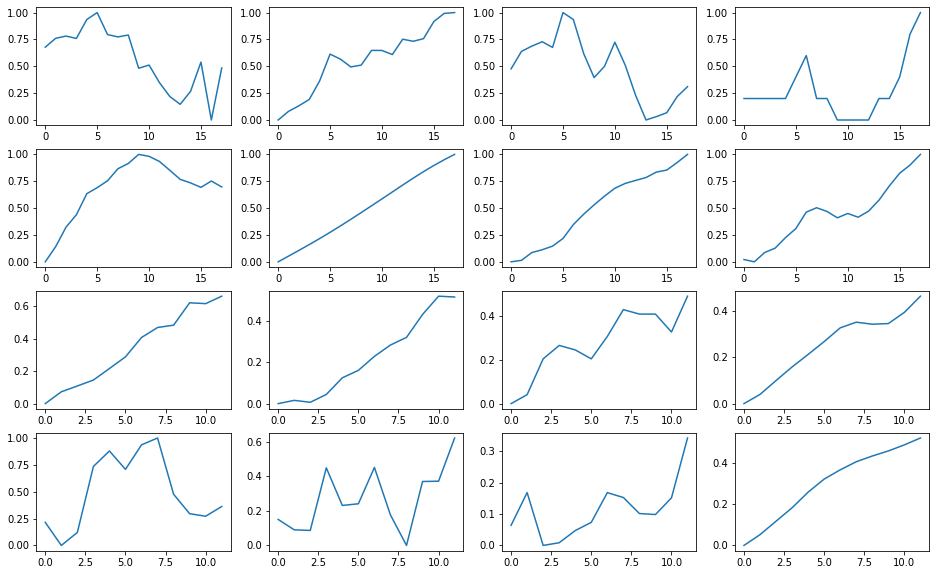

In [127]:
batch = data.__iter__().__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])

In [133]:
np.save('../data/foreaug__total_24__real_12__predby_6.npy', aug_dataset)